In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re

In [2]:
n_rows = 2000
n_signal_variables = 2
n_noise_variables = 2
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.normal(size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,noise_0,noise_1
0,2.300064,level_188,level_185,level_191,level_121
1,0.709092,level_94,level_309,level_159,level_294
2,-0.133198,level_96,level_287,level_165,level_112
3,2.351546,level_126,level_286,level_240,level_458
4,-1.853006,level_391,level_492,level_171,level_469


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,noise_0_impact_code,noise_1_impact_code
0,2.197718,2.197718,1.706187,1.172769
1,-0.441474,0.606746,-0.067600,0.427131
2,1.713430,1.586521,0.977160,2.262324
3,0.956606,1.304508,0.926682,2.570507
4,0.330670,-0.573870,-0.067600,0.802618


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,noise_0_impact_code,noise_1_impact_code
0,1.387779e-17,1.387779e-17,1.498966,9.212398e-01
1,-3.111526e-01,1.387779e-17,-0.055099,3.710141e-01
2,1.380509e+00,1.166408e+00,0.359670,2.024095e+00
3,6.563462e-01,1.097236e+00,0.239657,1.387779e-17
4,2.682630e-01,-3.799811e-01,-0.055099,7.332159e-01


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,noise_0_impact_code,noise_1_impact_code
0,0.000000,0.00000,1.106976,0.533964
1,0.000000,0.00000,-0.194538,0.324683
2,0.000000,0.00000,0.000000,1.585313
3,-0.550030,0.75828,0.000000,0.000000
4,0.850852,-1.14110,-0.411987,0.000000


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.793173,0.676472,0.284695,0.351831,False
1,var_1_impact_code,0.799877,0.680774,0.306911,0.305262,False
2,noise_0_impact_code,0.650917,0.506033,0.034147,0.016106,True
3,noise_1_impact_code,0.665980,0.504620,0.020893,0.021223,True


(0.9880862827985073, 0.011913717201492705)


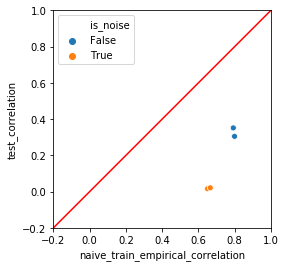

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.9922435667593333, 0.007756433240666662)


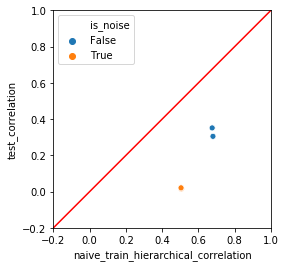

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.9854538985557645, 0.014546101444235519)


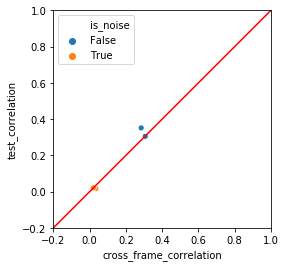

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
0,var_0_impact_code,impact_code,True,True,0.284695,8.016661e-20,4.0,True
1,var_1_impact_code,impact_code,True,True,0.306911,6.267105e-23,4.0,True
2,noise_0_impact_code,impact_code,True,True,0.034147,2.843311e-01,4.0,False
3,noise_1_impact_code,impact_code,True,True,0.020893,5.124837e-01,4.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code', 'var_1_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-0.133198,0.804453,0.804510,0.547919,0.772141
1,-1.853006,-0.900318,-0.877230,-0.588622,-0.894099
2,-1.994329,0.058670,0.112975,-0.309925,-0.539566
3,1.378056,0.486887,0.536321,0.004700,-0.076676
4,0.794605,0.111828,0.112975,0.176503,0.242162


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

0.6966946332087451


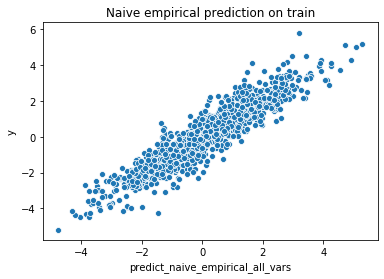

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

0.9787335038861217


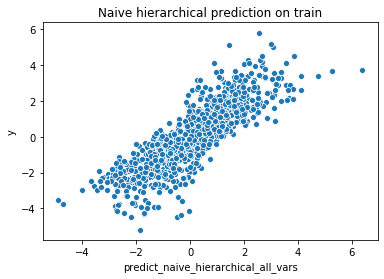

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

1.6476525492657883


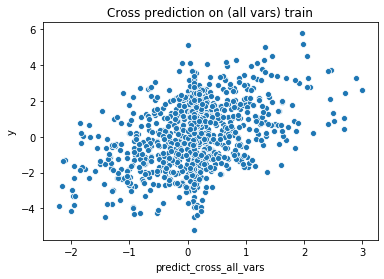

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

1.6493814656874075


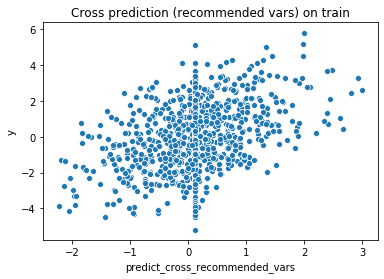

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

1.600495476479032


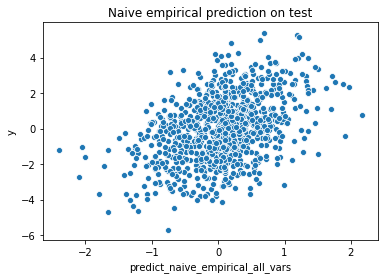

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

1.6092338792184373


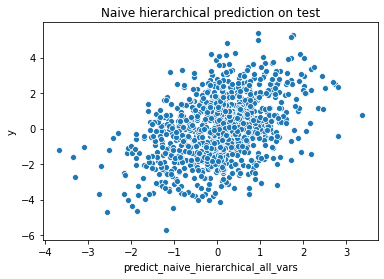

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

1.5690525251797085


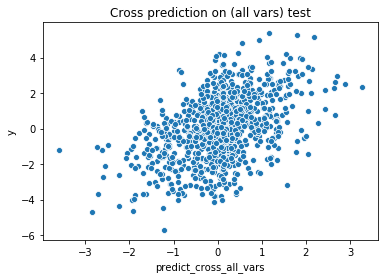

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

1.5698673251469002


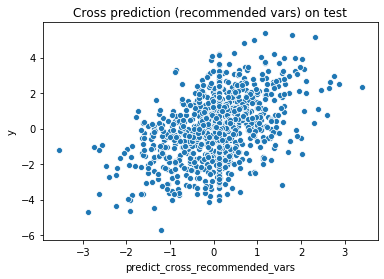

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1408.
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:22:29   Log-Likelihood:                -1041.7
No. Observations:                 985   AIC:                             2093.
Df Residuals:                     980   BIC:                             2118.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1023      0.022      4.599      0.000       0.059       0.146
var_0_impact_code       0.4525      0.021     21.398      0.000       0.411       0.494
var_1_impact_code       0.4759      0.021     22.838      0.000       0.435       0.517
noise_0_impact_code     0.2958      0.023     12.774      0.000       0.250       0.341
noise_1_impact_code     0.3096      0.023     13.553      0.000       0.265       0.354
==============================================================================
Omnibus:                        6.739   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                8.973
Skew:                           0.012   Prob(JB):                       0.0113
Kurtosis:                       3.467   Cond. No.                         2.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
smf = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     50.56
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           1.01e-38
Time:                        15:22:29   Log-Likelihood:                -1889.5
No. Observations:                 985   AIC:                             3789.
Df Residuals:                     980   BIC:                             3813.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1142      0.053      2.165      0.031       0.011       0.218
var_0_impact_code       0.6995      0.074      9.450      0.000       0.554       0.845
var_1_impact_code       0.7372      0.072     10.196      0.000       0.595       0.879
noise_0_impact_code     0.1446      0.105      1.372      0.170      -0.062       0.351
noise_1_impact_code     0.0417      0.094      0.442      0.659      -0.144       0.227
==============================================================================
Omnibus:                        6.376   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                4.740
Skew:                          -0.024   Prob(JB):                       0.0935
Kurtosis:                       2.664   Cond. No.                         2.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""